<a href="https://colab.research.google.com/github/SAMREYBEN64/AlgorithmsUN2024II/blob/main/LabATQ/sreyesb_LABATQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [2]:
! pip install git+https://github.com/quantiacs/toolbox.git

  Cloning https://github.com/quantiacs/toolbox.git to /tmp/pip-req-build-vzpjiprp
  Running command git clone --filter=blob:none --quiet https://github.com/quantiacs/toolbox.git /tmp/pip-req-build-vzpjiprp
  Resolved https://github.com/quantiacs/toolbox.git to commit 272e66e017d3eb6d40517ffa39cd6a92dc5072d8
  Preparing metadata (setup.py) ... done


In [3]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4147    0  4147    0     0  15379      0 --:--:-- --:--:-- --:--:-- 15416
100  517k  100  517k    0     0   409k      0  0:00:01  0:00:01 --:--:-- 1343k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4131    0  4131    0     0   7894      0 --:--:-- --:--:-- --:--:--  7898
100  392k  100  392k    0     0   361k      0  0:00:01  0:00:01 --:--:--  361k


In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable widget scrolling

<IPython.core.display.Javascript object>

In [6]:
import os

os.environ['API_KEY'] = '1bbbf67b-9500-47c1-9b18-a586d0d82136'
os.environ['DATA_BASE_URL'] = 'https://data-api.quantiacs.io/'
os.environ['CACHE_RETENTION'] = '7'
os.environ['CACHE_DIR'] = 'data-cache'

In [7]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [8]:
# Cargando datos de acciones del S&P 500
stock_data = qndata.stocks.load_spx_data(
    tail=365 * 5,
    assets=[
        "NAS:AAPL", "NAS:AMZN", "NAS:MSFT", "NAS:GOOGL", "NAS:TSLA",
        "NAS:META", "NAS:NVDA", "NYS:JPM", "NYS:V", "NYS:PG",
        "NYS:UNH", "NYS:HD", "NYS:DIS", "NYS:MA", "NAS:PYPL",
        "NAS:ADBE", "NAS:NFLX", "NYS:CRM", "NYS:KO", "NAS:PEP"
    ]
)
# Se seleccionaron estos 20 activos porque representan una diversidad de sectores dentro del índice S&P 500.
# Esto incluye tecnología (AAPL, MSFT, GOOGL, NVDA), consumo discrecional (AMZN, TSLA), servicios financieros (JPM, V, MA),
# atención médica (UNH), bienes de consumo (PG, KO, PEP), entretenimiento (DIS, NFLX), y otros.

| | #                                             | 15975 Elapsed Time: 0:00:00
| |#                                              | 15975 Elapsed Time: 0:00:00
| |      #                                       | 476396 Elapsed Time: 0:00:00


fetched chunk 1/1 3s
Data loaded 4s


In [9]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price.
       These features can be modified and new ones can be added easily.
    """

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)
    trend = trend.assign_coords(field="trend")

    # moving average convergence  divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)
    macd2_signal = macd2_signal.sel(field="close").rename({"field": "new_field"})
    macd2_signal = macd2_signal.assign_coords(field="macd").drop_vars("new_field")

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)
    volatility = volatility.assign_coords(field="volatility")

    # the stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)
    d = d.assign_coords(field="stochastic_d")

    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close"))
    rsi = rsi.assign_coords(field="rsi")

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0) # fill NaN
    price = np.log(price)
    price = price.assign_coords(field="price")

    # On-Balance Volume
    if 'volume' in data.field:
        obv = data.sel(field="close")
        volume = data.sel(field="volume")
        obv = volume.where(obv.diff("time") > 0, -volume).cumsum("time")
    else:
        # If 'volume' is not present, fill with 1s
        obv = xr.ones_like(data.sel(field="close"))
    obv = obv.assign_coords(field="obv")
    #  El OBV mide el flujo acumulado de volumen, ayudando a identificar movimientos de precios respaldados por volumen.

    # EMA (Exponential Moving Average)
    ema = qnta.ema(data.sel(field="close"), 20)
    ema = ema.assign_coords(field="ema")
    # La EMA proporciona una media ponderada que reacciona más rápidamente a los cambios de precios recientes.

    # ATR (Average True Range)
    true_range = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    atr = qnta.lwma(true_range, 14)
    atr = atr.assign_coords(field="atr")
    # El ATR mide la volatilidad del mercado considerando el rango verdadero promedio durante 14 períodos.

    # combine the six features:
    result = xr.concat(
        [trend, macd2_signal, volatility,  d, rsi, price, obv, ema, atr],
        pd.Index(
            ["trend",  "macd", "volatility", "stochastic_d", "rsi", "price", "obv", "ema", "atr"],
            name = "field"
        )
    )

    return result.transpose("time", "field", "asset")

In [10]:
# displaying the features:
my_features = get_features(stock_data)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:AAPL,NAS:ADBE,NAS:AMZN,NAS:GOOGL,NAS:META,NAS:MSFT,NAS:NFLX,NAS:NVDA,NAS:PEP,NAS:PYPL,NAS:TSLA,NYS:CRM,NYS:DIS,NYS:HD,NYS:JPM,NYS:KO,NYS:MA,NYS:PG,NYS:UNH,NYS:V
time,,,,,,,,,,,,,,,,,,,,
2020-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,0.197790,-0.338960,0.215067,0.257012,-0.010902,-0.037366,0.239628,-0.106488,-0.239387,0.036589,0.713199,0.130949,0.174467,-0.158547,0.076606,-0.142964,0.049530,-0.050616,-0.366914,0.152817
2025-01-02,0.102707,-0.357759,0.218922,0.251988,0.066019,-0.060286,0.211064,-0.015386,-0.272520,0.064329,0.467582,0.087193,0.150354,-0.160463,0.074016,-0.158034,0.020422,-0.082321,-0.367838,0.128505
2025-01-03,0.090928,-0.423893,0.269044,0.286079,0.094443,-0.025156,0.177777,0.125889,-0.278963,0.114480,0.720124,0.101532,0.151104,-0.152299,0.112223,-0.156760,0.010676,-0.098362,-0.311007,0.126577


In [11]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1 # prices goes up
    class_negative = 0 # price goes down

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [12]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data)
display(my_targetclass.to_pandas())

asset,NAS:AAPL,NAS:ADBE,NAS:AMZN,NAS:GOOGL,NAS:META,NAS:MSFT,NAS:NFLX,NAS:NVDA,NAS:PEP,NAS:PYPL,NAS:TSLA,NYS:CRM,NYS:DIS,NYS:HD,NYS:JPM,NYS:KO,NYS:MA,NYS:PG,NYS:UNH,NYS:V
time,,,,,,,,,,,,,,,,,,,,
2020-01-13,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,1
2020-01-14,0,0,0,1,1,1,1,0,1,1,0,0,0,1,0,1,1,1,1,1
2020-01-15,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1
2020-01-16,1,1,0,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,0,1
2020-01-17,0,1,1,1,0,0,0,0,1,1,1,1,0,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,0,0,1,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
2025-01-02,0,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,0,0,1,1
2025-01-03,1,1,1,1,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0


In [13]:
def get_model():
    """
      Se reemplazo Linear Regression con Random Forest Regressor
      Random Forest fue elegido porque captura relaciones no lineales e interacciones entre caracteristicas,
      que es tan presentes comunmente en la información financiera. Esto puede mejorar la precision de las predicciones para los precios de las acciones.
    """

    model = RandomForestRegressor(random_state=42)
    return model

In [14]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = stock_data.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", "any")
        features_cur = my_features.sel(asset=asset_name).dropna("time", "any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

print(models)

<ipython-input-14-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-14-383029879c06>:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-14-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-14-383029879c06>:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-14-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

{'NAS:AAPL': RandomForestRegressor(random_state=42), 'NAS:ADBE': RandomForestRegressor(random_state=42), 'NAS:AMZN': RandomForestRegressor(random_state=42), 'NAS:GOOGL': RandomForestRegressor(random_state=42), 'NAS:META': RandomForestRegressor(random_state=42), 'NAS:MSFT': RandomForestRegressor(random_state=42), 'NAS:NFLX': RandomForestRegressor(random_state=42), 'NAS:NVDA': RandomForestRegressor(random_state=42), 'NAS:PEP': RandomForestRegressor(random_state=42), 'NAS:PYPL': RandomForestRegressor(random_state=42), 'NAS:TSLA': RandomForestRegressor(random_state=42), 'NYS:CRM': RandomForestRegressor(random_state=42), 'NYS:DIS': RandomForestRegressor(random_state=42), 'NYS:HD': RandomForestRegressor(random_state=42), 'NYS:JPM': RandomForestRegressor(random_state=42), 'NYS:KO': RandomForestRegressor(random_state=42), 'NYS:MA': RandomForestRegressor(random_state=42), 'NYS:PG': RandomForestRegressor(random_state=42), 'NYS:UNH': RandomForestRegressor(random_state=42), 'NYS:V': RandomForestRe

Feature: 0, Score: 0.12782
Feature: 1, Score: 0.13018
Feature: 2, Score: 0.13109
Feature: 3, Score: 0.15394
Feature: 4, Score: 0.12133
Feature: 5, Score: 0.10353
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.11098
Feature: 8, Score: 0.12113


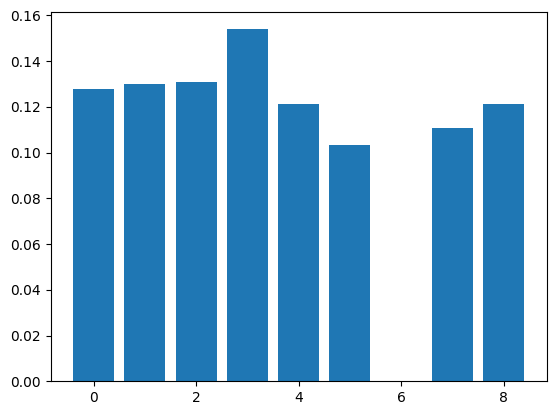

In [15]:
# Showing which features are more important in predicting:

# Use feature_importances_ instead of coef_
importance = models["NAS:AMZN"].feature_importances_
importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [16]:
# Performs prediction and generates output weights:

asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="close"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<ipython-input-16-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-16-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-16-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-16-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-16-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

<xarray.DataArray 'stocks_s&p500' (time: 1255, asset: 20)> Size: 201kB
array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.72, 0.75, 0.82, ..., 0.12, 0.9 , 0.21],
       [0.13, 0.27, 0.1 , ..., 0.81, 0.83, 0.05],
       [0.13, 0.23, 0.2 , ..., 0.23, 0.19, 0.09]])
Coordinates:
  * asset    (asset) <U9 720B 'NAS:AAPL' 'NAS:ADBE' ... 'NYS:UNH' 'NYS:V'
  * time     (time) datetime64[ns] 10kB 2020-01-13 2020-01-14 ... 2025-01-07
    field    <U5 20B 'close'


<ipython-input-16-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-16-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-16-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-16-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.



In [17]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

9.111038422027148

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

In [18]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2024-12-31,163.637440,-0.001768,0.197218,-0.013249,-0.143207,9.087928,1.792299,1.0,20.0,0.571385,3.338524
2025-01-02,163.955725,0.001945,0.197141,-0.011330,-0.143207,9.085368,1.791102,1.0,20.0,0.571627,3.338211
2025-01-03,166.731771,0.016932,0.197146,0.000000,-0.143207,9.121417,1.798249,1.0,20.0,0.571668,3.337653
2025-01-06,168.530105,0.010786,0.197089,0.000000,-0.143207,9.142994,1.801988,1.0,20.0,0.571551,3.337801
2025-01-07,167.302918,-0.007282,0.197078,-0.007282,-0.143207,9.111038,1.795583,1.0,20.0,0.572024,3.337899


time,2025-01-07
field,
sharpe_ratio,9.111038


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'



Ok. This strategy does not correlate with other strategies.


In [19]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

0.7626189916000228

In [20]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

0.76498017414845

In [21]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.1943171314741034

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [22]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", "any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [23]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [26]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...


| |#                                               | 9061 Elapsed Time: 0:00:00
| |        #                                    | 2299436 Elapsed Time: 0:00:00


fetched chunk 1/1 5s
Data loaded 5s


<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

fetched chunk 1/1 4s
Data loaded 4s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Run First Iteration...
fetched chunk 1/1 0s
Data loaded 0s


<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

---
Run all iterations...
Load data...


<ipython-input-23-df9da7badac1>:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

| |#                                               | 9061 Elapsed Time: 0:00:00
| |         #                                   | 2758137 Elapsed Time: 0:00:00


fetched chunk 1/8 2s


| |         #                                   | 2772835 Elapsed Time: 0:00:00


fetched chunk 2/8 4s


| |         #                                   | 2582205 Elapsed Time: 0:00:00


fetched chunk 3/8 7s


| |          #                                  | 3056444 Elapsed Time: 0:00:01


fetched chunk 4/8 9s


| |          #                                  | 3175627 Elapsed Time: 0:00:01


fetched chunk 5/8 11s


| |          #                                  | 3385341 Elapsed Time: 0:00:01


fetched chunk 6/8 14s


| |          #                                  | 3549175 Elapsed Time: 0:00:01


fetched chunk 7/8 16s


| |         #                                   | 3170733 Elapsed Time: 0:00:00


fetched chunk 8/8 19s
Data loaded 19s


| |#                                               | 9061 Elapsed Time: 0:00:00
| |          #                                  | 2869453 Elapsed Time: 0:00:01


fetched chunk 1/7 3s


| |         #                                   | 2960876 Elapsed Time: 0:00:00


fetched chunk 2/7 5s


| |          #                                  | 2994899 Elapsed Time: 0:00:01


fetched chunk 3/7 7s


| |         #                                   | 3204219 Elapsed Time: 0:00:00


fetched chunk 4/7 10s


| |          #                                  | 3461881 Elapsed Time: 0:00:01


fetched chunk 5/7 12s


| |          #                                  | 3543878 Elapsed Time: 0:00:01


fetched chunk 6/7 15s


| |         #                                   | 2645875 Elapsed Time: 0:00:00


fetched chunk 7/7 17s
Data loaded 18s
Backtest...


Streaming output truncated to the last 5000 lines.
Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was dep

fetched chunk 1/7 0s
fetched chunk 2/7 0s
fetched chunk 3/7 0s
fetched chunk 4/7 0s
fetched chunk 5/7 0s
fetched chunk 6/7 1s
fetched chunk 7/7 1s
Data loaded 1s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-01-07
Sharpe Ratio = 0.7340622505878674
Ok.
---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (5037 of 5037) |####################| Elapsed Time: 0:12:20 Time:  0:12:20


The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!